# Acknowledgement

Dataset ini diambil dari [kaggle.com](https://www.kaggle.com/datasets/ashishjangra27/face-mask-12k-images-dataset)

# Import Dataset

In [1]:
# from google.colab import drive

# drive.mount('/content/drive')

In [2]:
# !cp /content/drive/MyDrive/face-mask-12k-images-dataset.zip /content

In [3]:
# !unzip face-mask-12k-images-dataset.zip

Untuk struktur direktori kurang lebih seperti gambar dibawah ini.

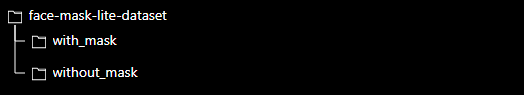

# Exploratory Data

In [4]:
import os

base_dir = 'Face Mask Dataset'

Mengambil 1 gambar dari setiap kelas untuk melihat bentuk gambar

In [5]:
sample_img = []
total_image_per_class = []
sample_title = os.listdir(base_dir)

for dir in os.listdir(base_dir):
  img_dir = os.path.join(base_dir, dir)
  total_image_per_class.append(len(os.listdir(img_dir)))
  sample_img.append(os.path.join(img_dir, os.listdir(img_dir)[0]))

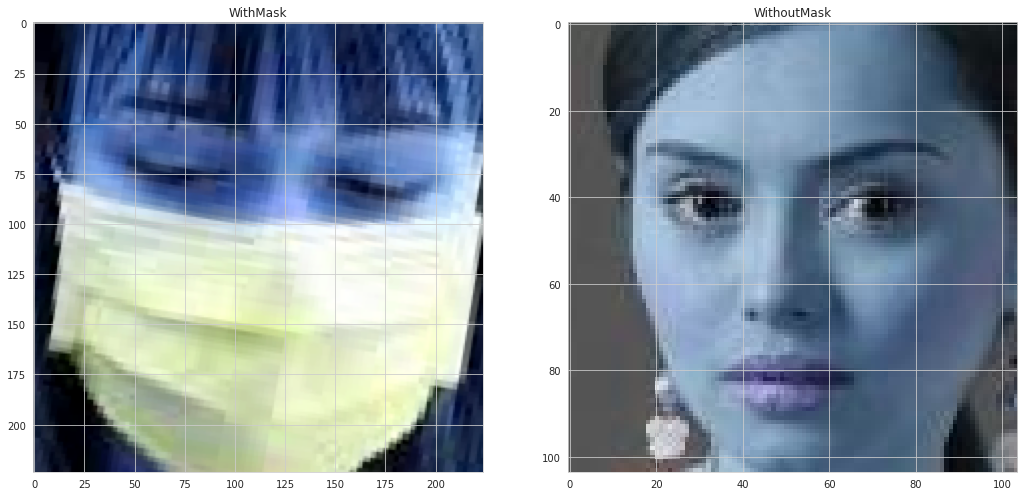

In [6]:
import cv2
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
%matplotlib inline
sns.set_style('whitegrid')

fig, ax = plt.subplots(1, 2, figsize=(15,7))
for i in range(2):
  img = cv2.imread(sample_img[i])
  ax[i].title.set_text(sample_title[i])
  ax[i].imshow(img)
fig.tight_layout()

Dari sampel gambar yang diambil kita bisa lihat ukurang dari gambar tidak seragam. Hal itu tidak menjadi masalah karena gambar akan kita kompres. Setelah melihat gambar sampel, selanjutnya kita akan melihat distribusi dari gambar pada setiap kelas

In [7]:
import pandas as pd

df = pd.DataFrame({
    'label': os.listdir(base_dir),
    'total_images': total_image_per_class
})

df

,label,total_images
0,WithMask,5400
1,WithoutMask,5400


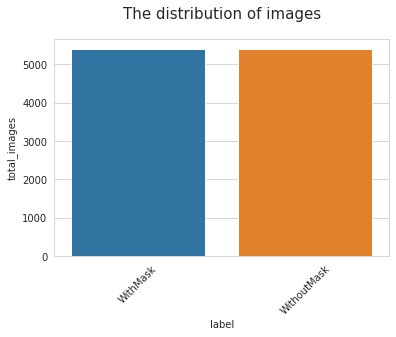

In [8]:
plt.xticks(rotation=45)
plt.title('The distribution of images', fontsize=15, pad=20)
sns.barplot(x='label', y='total_images', data=df)

# Data Preprocessing

Sebelum memasukan data ke dalam model, kita perlu melakukan pra pemrosesan data dengan melakukan image augmentation untuk menghasilkan lebih banyak gambar

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    shear_range=.2,
    validation_split=.2
)

valid_datagen = ImageDataGenerator(rescale=1./255, validation_split=.2)

In [10]:
img_size = 128
batch_size = 128
num_classes = len(os.listdir(base_dir))
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

valid_generator = valid_datagen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 8640 images belonging to 2 classes.
Found 2160 images belonging to 2 classes.


# Modeling

In [11]:
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dropout, Dense

model = Sequential([
    Conv2D(64, 3, activation='relu', input_shape=(img_size, img_size, 3)),
    Conv2D(64, 3, activation='relu'),
    BatchNormalization(),
    Conv2D(128, 3, activation='relu'),
    Conv2D(128, 3, activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(256, 3, activation='relu'),
    Conv2D(256, 3, activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dropout(.2),
    Dense(512, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 64)      36928     
                                                                 
 batch_normalization (BatchN  (None, 124, 124, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 122, 122, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 120, 120, 128)     147584    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 60, 128)      0         
 )                                                      

In [12]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [13]:
from keras.callbacks import Callback

threshold = .98
class Callback(Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') > threshold and logs.get('val_accuracy') > threshold:
      print(f'\nStopping training. Accuracy has reached {threshold * 100}%')
      self.model.stop_training = True

In [14]:
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=valid_generator,
    callbacks=[Callback()]
)

Epoch 1/100
68/68 [==============================] - 114s 1s/step - loss: 1.3662 - accuracy: 0.8584 - val_loss: 0.4727 - val_accuracy: 0.9241
Epoch 2/100
68/68 [==============================] - 66s 957ms/step - loss: 0.1046 - accuracy: 0.9620 - val_loss: 0.3810 - val_accuracy: 0.9319
Epoch 3/100
68/68 [==============================] - 67s 981ms/step - loss: 0.0563 - accuracy: 0.9808 - val_loss: 0.1894 - val_accuracy: 0.9685
Epoch 4/100
68/68 [==============================] - 66s 971ms/step - loss: 0.0432 - accuracy: 0.9837 - val_loss: 0.3968 - val_accuracy: 0.7769
Epoch 5/100
68/68 [==============================] - 68s 988ms/step - loss: 0.0380 - accuracy: 0.9859 - val_loss: 0.1198 - val_accuracy: 0.9574
Epoch 6/100
68/68 [==============================] - ETA: 0s - loss: 0.0338 - accuracy: 0.9884
Stopping training. Accuracy has reached 98.0%
68/68 [==============================] - 67s 976ms/step - loss: 0.0338 - accuracy: 0.9884 - val_loss: 0.0667 - val_accuracy: 0.9815


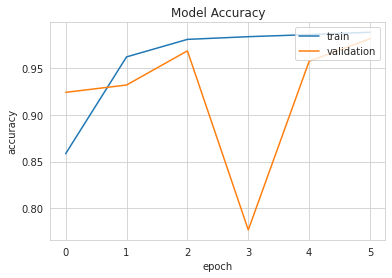

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

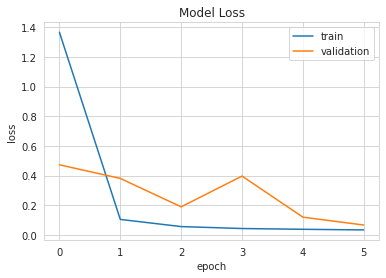

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [17]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
  f.write(tflite_model)